In [1]:
import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\user\\PycharmProjects\\Open_Close_GNN'])

Python 3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)] on win32


In [2]:
from model.dataset import OpenCloseDataset
from model.gnn_model import GCN, GATv2
import os
from model.utils import train, device, train_epoch, eval_epoch, cross_val
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch_geometric.loader import DataLoader

from seaborn import heatmap

In [5]:
import torch
from torch_geometric.data import Dataset, Data
from torch_geometric.utils import dense_to_sparse
from scipy.sparse import coo_matrix
import numpy as np
import os
import shutil
from scipy.io import loadmat


class OpenCloseDataset(Dataset):
    def __init__(self, datafolder, open_file, close_file, 
                 reload=False, test=False, transform=None, 
                 pre_transform=None, k_degree=10, edge_attr=None,
                 noise_close=None, win_close=None, noise_open=None, win_open=None, 
                 noise_n=20, win_n=100):

        self.reload = reload
        self.test = test
        self.datafolder = datafolder
        self.close = close_file
        self.open  = open_file
        self.edge_attr = edge_attr
        self.k_degree = k_degree
        self.outliers = np.array([256, 257, 258, 259]) 
        # [52, 256, 53, 257, 54, 258, 55, 259]

        if noise_close is not None:
            idx = np.random.choice(np.arange(len(noise_close)), noise_n)
            self.close = np.concatenate([
                self.close, noise_close[idx]])
            self.open = np.concatenate([
                self.open, noise_open[idx]])

        if win_close is not None:
            idx = np.random.choice(np.arange(len(win_close)), win_n)
            self.close = np.concatenate([
                self.close, win_close[idx]])
            self.open = np.concatenate([
                self.open, win_open[idx]])            

        if self.reload:
            for root, dirs, files in os.walk(f'{self.datafolder}/processed'):
                for f in files:
                    os.unlink(os.path.join(root, f))
                for d in dirs:
                    shutil.rmtree(os.path.join(root, d))

        super().__init__(root=datafolder, transform=transform, pre_transform=pre_transform)

    @property
    def raw_file_names(self):
        return ['open_84.npy', 'close_84.npy']
    
    @property
    def processed_file_names(self):
        return [f'data_{i}.pt' for i in range(len(self.close) + len(self.open))]
        
    def len(self):
        return len(self.close) + len(self.open)
    
    def process(self):

        for index in range(len(self.open)):
            _ = self._load_and_save(self.open[index], index, 'open')

        for index in range(len(self.close)):
            _ = self._load_and_save(self.close[index], index, 'close')

    def _load_and_save(self, matr, index, state):

        #np.fill_diagonal(matr, 0)
        matr = np.delete(matr, self.outliers, 0)
        matr = np.delete(matr, self.outliers, 1)

        x = torch.from_numpy(matr).float()

        if self.k_degree is not None:
            adj = self.compute_KNN_graph(matr, k_degree=self.k_degree)
            adj = torch.from_numpy(adj).float()
            edge_index, edge_attr = dense_to_sparse(adj)
            self.edge_attr = edge_attr
        else:
            edge_index = self._adjacency_threshold(x)

        label = torch.tensor(0 if state == 'close' else 1).long()
        data = Data(x=x, edge_index=edge_index, edge_attr=self.edge_attr, y=label)
        index = index + len(self.open) if state == 'close' else index

        if self.test:
            torch.save(data,
                       os.path.join(self.processed_dir, 'test_'
                                    f'data_{index}.pt'))
        else:
            torch.save(data,
                       os.path.join(self.processed_dir,
                                    f'data_{index}.pt'))
        return data
    
    def compute_KNN_graph(self, matrix, k_degree):
        """ Calculate the adjacency matrix from the connectivity matrix."""

        matrix = np.abs(matrix)
        idx = np.argsort(-matrix)[:, 0:k_degree]
        matrix.sort()
        matrix = matrix[:, ::-1]
        matrix = matrix[:, 0:k_degree]

        A = self._adjacency(matrix, idx).astype(np.float32)

        return A

    def _adjacency(self, dist, idx):

        m, k = dist.shape
        assert m, k == idx.shape
        assert dist.min() >= 0

        # Weight matrix.
        I = np.arange(0, m).repeat(k)
        J = idx.reshape(m * k)
        V = dist.reshape(m * k)
        W = coo_matrix((V, (I, J)), shape=(m, m))

        # No self-connections.
        W.setdiag(0)

        # Non-directed graph.
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)

        return W.todense()

    def _adjacency_threshold(self, matr, threshold=0.5):
        # todo optimize ???
        # todo переделать порог
        idx = []
        for i in range(len(matr)):
            for j in range(len(matr)):
                if abs(matr[i, j]) > threshold:
                    idx.append((i, j))

        return torch.tensor(idx).long().t().contiguous()

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 'test_'
                                           f'data_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir,
                                           f'data_{idx}.pt'))
        return data

In [3]:
close_file = np.load('../data/new/raw/close_84.npy') 
open_file  = np.load('../data/new/raw/open_84.npy')

In [4]:
noised_close = np.load('../data/new/raw/noised_close.npy')
noised_open  = np.load('../data/new/raw/noised_open.npy')

In [6]:
plt.figure(figsize=(5, 10))
plt.plot(close_file[0])
plt.plot(noised_close[0])

Error in callback <function flush_figures at 0x0000019B7C5FD288> (for post_execute):


KeyboardInterrupt: 

In [8]:
full_dataset = OpenCloseDataset(datafolder='../data/new', 
                                open_file=open_file, close_file=close_file, 
                                reload=True, k_degree=50, noise_n=25, noise_close=noised_close, noise_open=noised_open)

print(len(os.listdir('../data/new/processed')))

Processing...


220


Done!


In [10]:
test_idx = np.random.choice(np.arange(84*2, dtype=int), 20).tolist()
train_idx = np.delete(np.arange(len(full_dataset)), test_idx).tolist()
test_dataset = full_dataset[test_idx[:10]]
train_dataset = full_dataset[train_idx]
val_dataset = full_dataset[test_idx[10:]]

In [11]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

## GCN

In [12]:
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, global_max_pool, GCNConv, GATv2Conv, BatchNorm

class GCN(nn.Module):
    def __init__(self, num_features, channels, dropout=.3):
        super().__init__()
        self.conv1 = GCNConv(int(num_features), channels[0])
        self.bn1 = BatchNorm(channels[0])
        self.conv2 = GCNConv(channels[0], channels[1])
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(channels[1], 2)

    def forward(self, x, edge_index, edge_attr, batch):
        #x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        #batch = data.batch
        x = self.relu(self.conv1(x, edge_index, edge_attr))
        x = self.bn1(x)
        x = self.relu(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = global_max_pool(x, batch)
        x = self.lin1(x)
        return x

In [71]:
torch.cuda.empty_cache()

In [13]:
model = GCN(full_dataset.num_features, channels=[128, 32], dropout=0.3).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 15
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


58594

In [14]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=None, save_best=True, path_to_save='../weights/gcn_128_32_05.pt')

  0%|          | 0/15 [00:00<?, ?it/s]

TypeError: forward() missing 3 required positional arguments: 'edge_index', 'edge_attr', and 'batch'

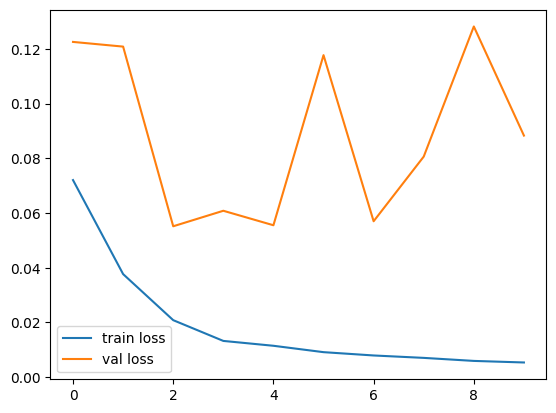

In [28]:
# при датасете 7к
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend();

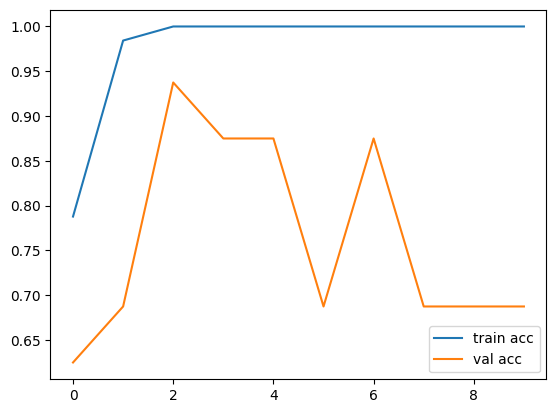

In [29]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='val acc')
plt.legend();

In [30]:
np.mean(test_acc)

0.7625

In [31]:
test_loader = DataLoader(test_dataset)
eval_epoch(test_loader, model, loss)
# loss, acc, precision, recall

torch.Size([422, 422])
torch.Size([2, 27128])
torch.Size([422, 422])
torch.Size([2, 25596])
torch.Size([422, 422])
torch.Size([2, 26428])
torch.Size([422, 422])
torch.Size([2, 26978])
torch.Size([422, 422])
torch.Size([2, 27128])
torch.Size([422, 422])
torch.Size([2, 26960])
torch.Size([422, 422])
torch.Size([2, 28146])
torch.Size([422, 422])
torch.Size([2, 28282])
torch.Size([422, 422])
torch.Size([2, 28304])
torch.Size([422, 422])
torch.Size([2, 26962])


(0.6817962378263474, 0.6, 0.1, 0.1)

In [40]:
test_input_tensor = [i for i in test_dataset]

In [31]:
import torch.nn as nn
from torch_geometric.nn import global_mean_pool, global_max_pool, GCNConv, GATv2Conv, BatchNorm

class GCN(nn.Module):
    def __init__(self, num_features, channels, dropout=.3):
        super().__init__()
        self.conv1 = GCNConv(int(num_features), channels[0])
        self.bn1 = BatchNorm(channels[0])
        self.conv2 = GCNConv(channels[0], channels[1])
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.lin1 = nn.Linear(channels[1], 2)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch
        #print(x.shape)
        #print(edge_index.shape)
        #print(edge_attr.shape)
        x = self.relu(self.conv1(x, edge_index, edge_attr))
        x = self.bn1(x)
        x = self.relu(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = global_max_pool(x, batch)
        x = self.lin1(x)
        return x

In [29]:
import torch
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from torch_geometric.loader import DataLoader
from torchmetrics.classification import BinaryRecall, BinaryPrecision, BinaryAccuracy


def train_epoch(train_loader, model, criterion, optimizer):
    model.train()
    for data in train_loader:
        data = data.to(device())
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


def eval_epoch(loader, model, criterion):
    model.eval()
    losses = 0
    acc, pr, rc = [], [], []
    accuracy = BinaryAccuracy()
    precision = BinaryPrecision()
    recall = BinaryRecall()

    with torch.no_grad():
        for data in loader:
            data = data.to(device())
            out = model(data)
            loss = criterion(out, data.y)
            losses += loss.item()
            pred = out.argmax(dim=1)
            acc.append(accuracy(pred.cpu(), data.y.cpu()))
            pr.append(precision(pred.cpu(), data.y.cpu()))
            rc.append(recall(pred.cpu(), data.y.cpu()))

    return losses / len(loader.dataset), np.mean(acc), np.mean(pr), np.mean(rc)


def train(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler=None, save_best=False, path_to_save=None):

    history = []
    best_val_loss = 1000
    for epoch in tqdm(range(1, epochs+1)):
        train_epoch(train_loader, model, criterion, optimizer)
        train_loss, train_acc, train_prec, train_rec = eval_epoch(train_loader, model, criterion)
        val_loss, test_acc, test_prec, test_rec = eval_epoch(val_loader, model, criterion)
        if scheduler is not None:
            scheduler.step()

        if save_best:
            if best_val_loss > val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), path_to_save)


        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

        print(f'Test precision: {test_prec:.4f}, Test recall: {test_rec:.4f}')
        # f'Train precision: {train_prec:.4f}, Train recall: {train_rec:.4f}, '
        history.append((train_loss, val_loss, train_acc, test_acc))

    if save_best:
        model.load_state_dict(torch.load(path_to_save, map_location=device()))

    return history

In [32]:
model = GCN(full_dataset.num_features, channels=[128, 32], dropout=0.5).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()
epochs = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=True)
sum(p.numel() for p in model.parameters())

Adjusting learning rate of group 0 to 1.0000e-03.


58594

In [18]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, 
                scheduler=None, save_best=True, path_to_save='../weights/gcn_128_32_05.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([3376, 422])
torch.Size([2, 216682])
torch.Size([3376, 422])
torch.Size([2, 215782])
torch.Size([3376, 422])
torch.Size([2, 214082])
torch.Size([3376, 422])
torch.Size([2, 214402])
torch.Size([3376, 422])
torch.Size([2, 216426])
torch.Size([3376, 422])
torch.Size([2, 215332])
torch.Size([3376, 422])
torch.Size([2, 216418])
torch.Size([3376, 422])
torch.Size([2, 214086])
torch.Size([3376, 422])
torch.Size([2, 212506])
torch.Size([3376, 422])
torch.Size([2, 215694])
torch.Size([3376, 422])
torch.Size([2, 213914])
torch.Size([3376, 422])
torch.Size([2, 216526])
torch.Size([3376, 422])
torch.Size([2, 219492])
torch.Size([3376, 422])
torch.Size([2, 218768])
torch.Size([3376, 422])
torch.Size([2, 215936])
torch.Size([3376, 422])
torch.Size([2, 216716])
torch.Size([3376, 422])
torch.Size([2, 218854])
torch.Size([3376, 422])
torch.Size([2, 213850])
torch.Size([3376, 422])
torch.Size([2, 215248])
torch.Size([3376, 422])
torch.Size([2, 217926])
torch.Size([3376, 422])
torch.Size([2, 2

In [33]:
model.load_state_dict(torch.load('../weights/gcn_128_32_05_acc_09.pt', map_location=device()))

<All keys matched successfully>

In [32]:
from copy import copy
inp_tensor = copy(test_dataset[0].x)

In [19]:
import captum

from captum.attr import Saliency, IntegratedGradients

In [34]:
ig = IntegratedGradients(model.to('cpu'))
#model.eval()
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_dataset[0].x,
                           target=1, return_convergence_delta=True,
                           additional_forward_args=(test_dataset[0].edge_index, test_dataset[0].edge_attr, test_dataset[0].batch),
                           internal_batch_size=1)
#attr = attr.detach().numpy()

AttributeError: 'NoneType' object has no attribute 'dtype'

In [35]:
sal = Saliency(model.to('cpu'))
mask = sal.attribute(test_dataset[0].x, 
                     additional_forward_args=(test_dataset[0].edge_index, test_dataset[0].edge_attr, test_dataset[0].batch),
                     target=test_dataset[0].y)

AssertionError: `inputs` must be a torch.Tensor or a tuple[torch.Tensor] but found: <class 'torch_geometric.data.data.Data'>

In [25]:
edge_mask = np.abs(mask.cpu().detach().numpy())
if edge_mask.max() > 0:  # avoid division by zero
    edge_mask = edge_mask / edge_mask.max()

In [67]:
np.argsort(edge_mask[0])[::-1][:10]

array([419, 201, 307,   3, 340, 376, 352, 281,  55, 342], dtype=int64)

In [69]:
np.argmax(edge_mask[421])

346

In [22]:
from nilearn.plotting import plot_connectome
import pandas as pd

hcp = pd.read_excel('../data/HCPex_sorted.xlsx')
hcp.drop([256, 257, 258, 259], inplace=True)

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\nilearn\__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [95]:
salient_connections = np.zeros((422, 422))
for i in range(422):
    salient_connections[i] = edge_mask[i] > 0.6

In [98]:
np.sum(salient_connections, axis=1) != 0

array([False,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False,  True, False, False,  True,  True, False, False,
        True,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [102]:
np.sum(salient_connections, axis=1) != 0 * np.sum(salient_connections, axis=1)

array([False,  True,  True,  True,  True,  True, False, False, False,
       False,  True,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True, False,  True, False, False,  True,  True, False, False,
        True,  True, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [100]:
np.argsort(np.sum(salient_connections, axis=1) != 0)

array([  0, 285, 284, 283, 282, 281, 280, 279, 278, 277, 276, 286, 275,
       273, 272, 271, 270, 269, 268, 267, 266, 265, 264, 274, 263, 287,
       289, 312, 311, 310, 309, 308, 307, 306, 305, 304, 303, 288, 302,
       299, 298, 297, 296, 295, 294, 293, 292, 291, 290, 300, 313, 262,
       260, 233, 232, 231, 229, 228, 227, 226, 225, 224, 223, 234, 222,
       220, 219, 218, 217, 215, 214, 213, 211, 420, 209, 221, 261, 235,
       237, 259, 258, 257, 256, 255, 254, 253, 252, 251, 250, 236, 249,
       247, 246, 245, 244, 243, 242, 241, 240, 239, 238, 248, 208, 314,
       316, 393, 392, 391, 390, 389, 388, 387, 385, 384, 383, 394, 382,
       380, 379, 378, 377, 376, 375, 374, 373, 372, 371, 381, 370, 395,
       397, 419, 418, 417, 416, 415, 414, 413, 412, 411, 410, 396, 409,
       407, 406, 405, 404, 403, 402, 401, 400, 399, 398, 408, 315, 369,
       367, 339, 338, 337, 336, 335, 334, 333, 332, 331, 330, 340, 329,
       327, 326, 325, 324, 323, 321, 320, 319, 318, 317, 328, 36

In [ ]:
salient_connections1 = np.zeros((422, 422))
for i in range(422):
    a = np.argsort(edge_mask[0])[::-1][:10]
    salient_connections1[i][a] = 1.



C:\Users\user\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\displays\_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


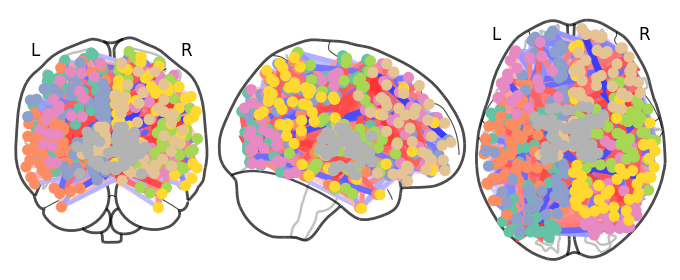

In [89]:
plot_connectome(salient_connections * test_dataset[0].x.numpy(), hcp[['X', 'Y', 'Z']].values)

<AxesSubplot:>

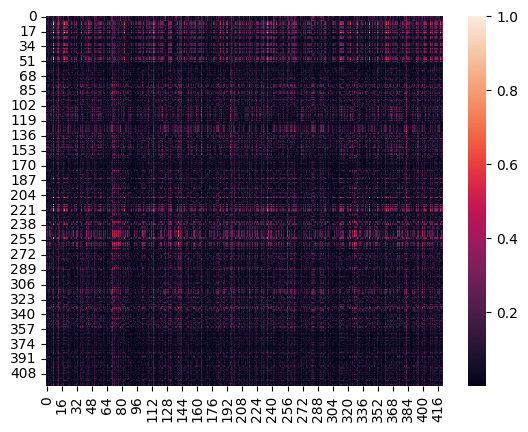

In [26]:
heatmap(edge_mask)

## GAT

In [30]:
model = GATv2(full_dataset.num_features, 128, 8, dropout=0.1).to(device())
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
epochs = 15
scheduler = lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.1, last_epoch=-1, verbose=False)
sum(p.numel() for p in model.parameters())

223794

In [31]:
history = train(model, epochs, train_loader, val_loader, loss, optimizer, scheduler=None)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 001, Train Loss: 0.0823, Test Loss 0.0882, Train Acc: 0.6618, Test Acc: 0.5321
Test precision: 0.5211, Test recall: 0.8214
Epoch: 002, Train Loss: 0.0642, Test Loss 0.0723, Train Acc: 0.8125, Test Acc: 0.7679
Test precision: 0.7269, Test recall: 0.8810
Epoch: 003, Train Loss: 0.0519, Test Loss 0.0627, Train Acc: 0.8676, Test Acc: 0.8000
Test precision: 0.7388, Test recall: 0.9357
Epoch: 004, Train Loss: 0.0406, Test Loss 0.0525, Train Acc: 0.8934, Test Acc: 0.8286
Test precision: 0.7952, Test recall: 0.8048
Epoch: 005, Train Loss: 0.0324, Test Loss 0.0443, Train Acc: 0.9228, Test Acc: 0.8929
Test precision: 0.8429, Test recall: 0.9524
Epoch: 006, Train Loss: 0.0259, Test Loss 0.0373, Train Acc: 0.9559, Test Acc: 0.9286
Test precision: 0.8881, Test recall: 0.9524
Epoch: 007, Train Loss: 0.0211, Test Loss 0.0322, Train Acc: 0.9669, Test Acc: 0.9286
Test precision: 0.9082, Test recall: 0.9524
Epoch: 008, Train Loss: 0.0171, Test Loss 0.0275, Train Acc: 0.9706, Test Acc: 0.9464
Test

In [32]:
eval_epoch(test_loader, model, loss)
# loss, acc, precision, recall

(0.042375238029004926, 1.0, 0.73333335, 0.73333335)

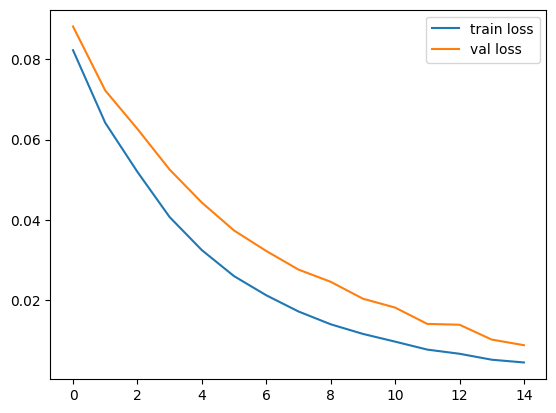

In [33]:
train_loss, val_loss, train_acc, test_acc = zip(*history)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend();

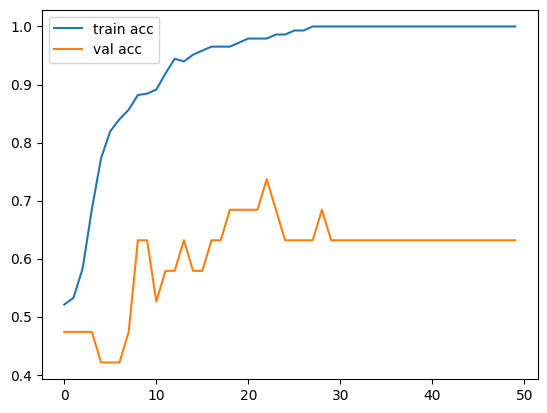

In [68]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='val acc')
plt.legend();

In [69]:
np.mean(test_acc)

0.6052631

In [22]:
torch.save(model.state_dict(), '../weights/gat_2heads_128_8_knn10_crossval.pt')

## Cross-validation

In [71]:
# GCN

from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=6, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))
crossval_dataset = train_dataset #+ val_dataset

labels = [crossval_dataset[i].y for i in range(len(crossval_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GCN(crossval_dataset.num_features, channels=[256, 32], dropout=0.3).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30//3, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(crossval_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(crossval_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(20):
        train_epoch(train_loader_, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader_, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(test_loader_, model, criterion)
        #scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

0
Epoch: 000, Train Loss: 0.0806, Test Loss 0.0879, Train Acc: 0.8482, Test Acc: 0.6964
Epoch: 001, Train Loss: 0.0637, Test Loss 0.0830, Train Acc: 0.9643, Test Acc: 0.5714
Epoch: 002, Train Loss: 0.0406, Test Loss 0.0759, Train Acc: 0.9809, Test Acc: 0.6488
Epoch: 003, Train Loss: 0.0219, Test Loss 0.0730, Train Acc: 1.0000, Test Acc: 0.6190
Epoch: 004, Train Loss: 0.0113, Test Loss 0.0671, Train Acc: 1.0000, Test Acc: 0.6548
Epoch: 005, Train Loss: 0.0062, Test Loss 0.0630, Train Acc: 1.0000, Test Acc: 0.7024
Epoch: 006, Train Loss: 0.0036, Test Loss 0.0708, Train Acc: 1.0000, Test Acc: 0.6905
Epoch: 007, Train Loss: 0.0022, Test Loss 0.0642, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 008, Train Loss: 0.0014, Test Loss 0.0653, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 009, Train Loss: 0.0010, Test Loss 0.0715, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 010, Train Loss: 0.0008, Test Loss 0.0689, Train Acc: 1.0000, Test Acc: 0.7440
Epoch: 011, Train Loss: 0.0006, Test Loss 0.0714, Tr

In [72]:
eval_epoch(test_loader, model, loss)

(0.7578488029335858, 0.6666667, 0.4, 0.4)

In [36]:
eval_metrics
# acc during minimal loss, mean acc, std

array([[0.64285713, 0.61398804, 0.06108881],
       [0.91666669, 0.80565482, 0.14652142],
       [0.72222227, 0.69999993, 0.07275445],
       [0.625     , 0.64027774, 0.06068347],
       [0.7638889 , 0.72847223, 0.09249154],
       [0.6388889 , 0.58541662, 0.06074304]])

In [73]:
# mean acc across all folds 
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.685482790072759, 0.05847524153388064)

In [38]:
# GAT

from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

skf = StratifiedKFold(n_splits=6, shuffle=True)
eval_metrics = np.zeros((skf.n_splits, 3))

labels = [train_dataset[i].y for i in range(len(train_dataset))]


for n_fold, (train_idx, test_idx) in tqdm(enumerate(skf.split(labels, labels))):
    model = GATv2(train_dataset.num_features, 128, 8).to(device())
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = lr_scheduler.StepLR(optimizer, step_size=30//3, gamma=0.1, last_epoch=-1, verbose=False)

    train_loader_ = DataLoader(train_dataset[list(train_idx)], batch_size=8, shuffle=True)
    test_loader_ = DataLoader(train_dataset[list(test_idx)], batch_size=8, shuffle=True)
    min_v_loss = np.inf
    print(n_fold)
    pr, rc, acc = [], [], []
    for epoch in range(20):
        train_epoch(train_loader_, model, criterion, optimizer)
        train_loss, train_acc, _, _ = eval_epoch(train_loader_, model, criterion)
        val_loss, test_acc, _, _ = eval_epoch(test_loader_, model, criterion)
        #scheduler.step()
        print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss {val_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        #print(f'Train Prec: {train_pr:.3f}, Train Rec: {train_rc:.3f}, Test Prec: {val_pr:.3f}, Test Rec: {val_rc:.3f}')
        #rc.append(val_rc)
        #pr.append(val_pr)
        acc.append(test_acc)
        if min_v_loss > val_loss:
            min_v_loss = val_loss
            best_test_acc = test_acc

    eval_metrics[n_fold, 0] = best_test_acc
    eval_metrics[n_fold, 1] = np.mean(acc)
    eval_metrics[n_fold, 2] = np.std(acc)
### eval_metrics[n_fold, 3] =

0it [00:00, ?it/s]

0
Epoch: 000, Train Loss: 0.0821, Test Loss 0.0891, Train Acc: 0.7092, Test Acc: 0.6548
Epoch: 001, Train Loss: 0.0528, Test Loss 0.0777, Train Acc: 0.9094, Test Acc: 0.7024
Epoch: 002, Train Loss: 0.0227, Test Loss 0.0716, Train Acc: 0.9643, Test Acc: 0.7857
Epoch: 003, Train Loss: 0.0094, Test Loss 0.0710, Train Acc: 0.9911, Test Acc: 0.6488
Epoch: 004, Train Loss: 0.0043, Test Loss 0.0774, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 005, Train Loss: 0.0020, Test Loss 0.0774, Train Acc: 1.0000, Test Acc: 0.6905
Epoch: 006, Train Loss: 0.0011, Test Loss 0.0833, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 007, Train Loss: 0.0008, Test Loss 0.0872, Train Acc: 1.0000, Test Acc: 0.7500
Epoch: 008, Train Loss: 0.0005, Test Loss 0.0853, Train Acc: 1.0000, Test Acc: 0.7381
Epoch: 009, Train Loss: 0.0004, Test Loss 0.0889, Train Acc: 1.0000, Test Acc: 0.6964
Epoch: 010, Train Loss: 0.0003, Test Loss 0.0902, Train Acc: 1.0000, Test Acc: 0.7321
Epoch: 011, Train Loss: 0.0002, Test Loss 0.0930, Tr

In [39]:
eval_metrics

array([[0.64880949, 0.72738093, 0.03720121],
       [0.64880949, 0.57589281, 0.05564362],
       [0.8611111 , 0.7520833 , 0.0579809 ],
       [0.77777773, 0.75972229, 0.04437928],
       [0.65277773, 0.72222221, 0.04143455],
       [0.65277773, 0.62499994, 0.04479031]])

In [40]:
np.mean(eval_metrics[:, 1]), np.std(eval_metrics[:, 1])

(0.6937169134616852, 0.06869462128180329)

In [41]:
eval_epoch(test_loader, model, loss)

(0.32423661667514003, 0.8, 0.46666667, 0.46666667)

## Explainability

In [ ]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, data):
    batch = torch.zeros(data.x.shape[0], dtype=int).to(device())
    out = model(data) # .x, data.edge_index, batch, edge_mask
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data.edge_index.shape[1]).requires_grad_(True).to(device)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data.edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask